In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import torch
import numpy as np
import json
import os
import cv2
import imutils
model = YOLO('best.pt')

In [2]:
results = model(["Hym0uqFL25A.jpg"], stream=True,imgsz=640)  # return a generator of Results objects

# Process results generator
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    result.show() 


0: 640x480 12 cards, 292.0ms
Speed: 6.0ms preprocess, 292.0ms inference, 1971.4ms postprocess per image at shape (1, 3, 640, 480)


In [3]:
import cv2
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors

model = YOLO("yolov8n-seg.pt")  # segmentation model
names = model.model.names
cap = cv2.VideoCapture("path/to/video/file.mp4")
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

out = cv2.VideoWriter('instance-segmentation.avi', cv2.VideoWriter_fourcc(*'MJPG'), fps, (w, h))

while True:
    ret, im0 = cap.read()
    if not ret:
        print("Video frame is empty or video processing has been successfully completed.")
        break

    results = model.predict(im0)
    annotator = Annotator(im0, line_width=2)

    if results[0].masks is not None:
        clss = results[0].boxes.cls.cpu().tolist()
        masks = results[0].masks.xy
        for mask, cls in zip(masks, clss):
            annotator.seg_bbox(mask=mask,
                               mask_color=colors(int(cls), True),
                               det_label=names[int(cls)])

    out.write(im0)
    cv2.imshow("instance-segmentation", im0)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

out.release()
cap.release()
cv2.destroyAllWindows()

Video frame is empty or video processing has been successfully completed.


In [4]:

def rounding_up(matrix): # заменяет все числа на 1 и 0
    """
    массив, что содержит в себе все цвета каждого пикселя преобразует числа цветов в 1 и нолики (0 - чёрный цвет, а 1 - белый цвет)
    """
    result = np.zeros_like(matrix)
    result[matrix > 130] = 1
    return result

def split_matrix(matrix, rows, cols):
    """
    разделяет список на 49 частей (то есть разделяет весь массив, картинку на матрицу 7 на 7 клеток), после избавляется от крайних столбцов и строк => выводит матрицу 5 на 5
    """
    row_size, col_size = rows // 7, cols // 7
    parts = []
    for i in range(7):
        for j in range(7):
            part = matrix[i * row_size : (i + 1) * row_size, j * col_size : (j + 1) * col_size]
            parts.append(part)

    central_parts = []
    for i in range(1, 6):
        for j in range(1, 6):
            central_parts.append(parts[i * 7 + j])
    
    return central_parts

def replace_based_on_center(parts):
    """
    округляет каждую часть списка до 1 или 0 на основе цвета центрального пикселя
    """
    replaced_parts = []
    for part in parts:
        center_pixel = part[len(part) // 2, len(part[0]) // 2]
        replaced_part = np.full_like(part, center_pixel)
        replaced_parts.append(replaced_part)
    return replaced_parts

def combine_parts(rounded_parts):
    """
    сохраняет всё в виде матрицы 5 на 5, где каждая клетка равна либо положительному числу, либо нулю
    """
    combined_matrix = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            part_index = i * 5 + j
            combined_matrix[i, j] = 1 if np.sum(rounded_parts[part_index]) > 0 else 0
    return combined_matrix

def read_from_json(filename):
    # Открытие файла для чтения
    with open(filename, 'r') as json_file:
        # Загрузка данных из файла
        data = json.load(json_file)
    return data

def load_json_to_matrices(filename):
    """
    загрузка базы данных в список matrices и преобразование его в словарь numpy
    """
    with open(filename, 'r') as json_file:
        data = json.load(json_file)

    matrices = {}
    for key, value in data.items():
        matrices[key] = np.array(value)
    
    return matrices

def compare_matrices(matrix1, matrices_from_json):
    """
    сравнение нашей матрицы с матрицами из базы данных
    """
    for key, matrix2 in matrices_from_json.items():
        if np.array_equal(matrix1, matrix2):
            return key
    return None

def main(picture, json_file): 
    """
    Финальная функция, что содержит в себе все предыдущие. main возвращает номер карточки и вариант её ответа, если же данная картачка не
    совпадает ни с одной из карточек из базы данных, то возвращается None. (Принимает на вход саму картинку и файл с базой данных)
    """
    cb_img = cv2.imread(picture, 0)
    cb_img_np = np.array(cb_img)
    plt.imshow(cb_img_np, cmap='gray')
    lines, columns = cb_img.shape
    the_converted_image = combine_parts(replace_based_on_center(split_matrix(rounding_up(cb_img_np), lines, columns)))
    return compare_matrices(the_converted_image, load_json_to_matrices(json_file))
    # Предполагаем, что cb_img_np уже является массивом numpy.ndarray, представляющим изображение в оттенках серого


def mainer(cb_img_np, json_file):
    """
    Финальная функция, что содержит в себе все предыдущие. main возвращает номер карточки и вариант её ответа, если же данная картачка не
    совпадает ни с одной из карточек из базы данных, то возвращается None. (Принимает на вход массив numpy.ndarray и файл с базой данных)
    """
    plt.imshow(cb_img_np, cmap='gray')
    lines, columns = cb_img_np.shape[:2]
    the_converted_image = combine_parts(replace_based_on_center(split_matrix(rounding_up(cb_img_np), lines, columns)))
    return compare_matrices(the_converted_image, load_json_to_matrices(json_file))


In [5]:
#Трансформация карточек
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect


def four_point_transform(image, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped

In [6]:
#поиск "крайних точек" карточки
def find_largest_contour(image):
    # Переводим изображение в оттенки серого
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Применяем пороговую обработку для получения бинарного изображения
    _, thresh = cv2.threshold(gray, 127, 255, 0)
    # Инвертируем бинарное изображение
    thresh = cv2.bitwise_not(thresh)
    # Находим контуры на инвертированном бинарном изображении
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Находим наибольший контур
    largest_contour = max(contours, key=cv2.contourArea)
    extreme_points = [(0, 0), (0, image.shape[0]), (image.shape[1], image.shape[0]),
                      (image.shape[1], 0)]  # Изначально углы изображения
    min_distances = [np.inf, np.inf, np.inf, np.inf]  # Изначально расстояния до углов
    # Перебор всех точек контура для поиска крайних
    for point in largest_contour:
        x, y = point[0][0], point[0][1]
        distances = [x, image.shape[0] - y, image.shape[1] - x, y]
        for i in range(4):
            if distances[i] < min_distances[i]:
                min_distances[i] = distances[i]
                extreme_points[i] = (x, y)
    return extreme_points

In [7]:
#функция вырезки карточек из изображения
def crop_images(img, coordinates):
    images = []
    for coords in coordinates:
        left, top, right, bottom = map(int, coords)
        cropped_img = img[top:bottom, left:right]
        images.append(cropped_img)
    return images

In [8]:
#----------------------------------------------------------------

In [18]:
#Получение изображения с карточками в ограничивающей рамке
def get_processed_photo(photo):
    photo=cv2.imread(photo)
    results=model(photo,conf=0.8)
    im_array = results[0].plot()
    return im_array
result_photo=get_processed_photo('122.jpg')
cv2.imshow('result',result_photo)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [29]:
#Сохранение вырезанных карточек без ориентации
def save_crop_photos(img,save_dir):
    results=model(img,conf=0.8)
    results[0].save_crop(save_dir)
save_crop_photos(cv2.imread('100.jpg'),'C:/Users/Admin/Downloads/dfdsf/save_img')

In [46]:
def save_image_with_sequence_number(image, directory, base_name):
    # Проверка существования директории, и если её нет, то создание
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Получение списка файлов в директории
    files = os.listdir(directory)
    
    # Вычисление номера для нового файла
    number = len(files) + 1
    
    # Составление имени файла с учетом базового имени и номера
    file_name = os.path.join(directory, f"{base_name}{number}.jpg")
    
    # Сохранение изображения
    cv2.imwrite(file_name, image)
    
    print(f"Изображение сохранено как {file_name}")


IndexError: index 0 is out of bounds for axis 0 with size 0

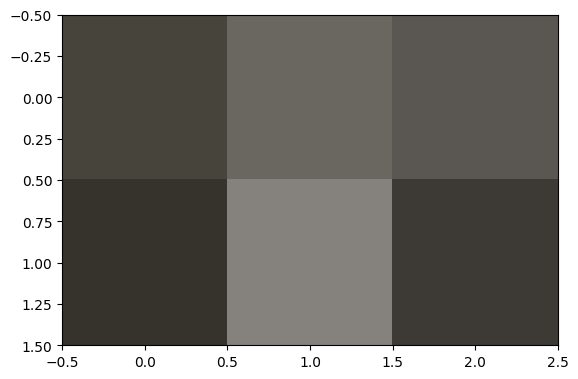

In [15]:
def get_results_photo2(img):
    answers=[]
    results=model(img,verbose=False)
    boxes = results[0].boxes.xyxy.cpu().tolist()
    images=crop_images(img,boxes)
    for i in range(len(images)):
        image=images[i]
        image = cv2.copyMakeBorder(image, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=(255, 255, 255))
        orig=image
        edged = cv2.Canny(image, 120, 255)
        cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
        screenCnt = None  # Initialize screenCnt outside the loop
        for c in cnts:
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            if len(approx) == 4:
                screenCnt = approx
                break
        if screenCnt is not None:  # Check if screenCnt is assigned a value
            warped = four_point_transform(orig, screenCnt.reshape(4, 2))
            #cv2.waitKey(0)
            #cv2.imshow("Original", image)
            #cv2.imshow("Warped", warped)  # Fixed typo: wrapped -> warped
            #cv2.waitKey(0)
           #cv2.destroyAllWindows()
            answers.append(mainer(warped,'image_database.json'))
    return answers
model = YOLO('best.pt')
print(get_results_photo2(cv2.imread("jnKym0mevRI.jpg")))

KeyboardInterrupt: 

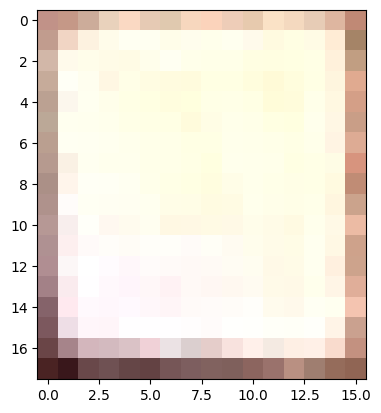

In [14]:

def extract_frames(video_path):
    ansvers=[]
    """
    Извлекает все кадры из видеофайла и возвращает их в виде списка массивов numpy.ndarray.
    
    :param video_path: Путь к видеофайлу.
    :return: Список кадров в виде массивов numpy.ndarray.
    """
    # Открываем видеофайл
    cap = cv2.VideoCapture(video_path)
    count=0
    frames = []
    while True:
        # Читаем кадр
        ret, frame = cap.read()
        count+=1
        # Если кадр был прочитан успешно, добавляем его в список
        if ret:
            if count%10==0:
                results = model([frame], stream=True,imgsz=640)  # return a generator of Results objects
                for result in results:
                    boxes = result.boxes  # Boxes object for bounding box outputs
                    result.show() 
            try:
                res=get_results_photo2(frame)
                for card in res:
                    if card!=None:
                        ansvers.append(card)
            except:
                pass
                
        else:
            # Если кадры закончились, выходим из цикла
            break
    
    # Освобождаем ресурсы
    cap.release()
    
    return frames

# Пример использования функции
video_frames = extract_frames('My-video-Дата.mp4')
print(video_frames)

In [27]:
#демонстрация работы модели на видео
def real_time_video(video_path):
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        # Read a frame from the video
        success, frame = cap.read()

        if success:
            # Run YOLOv8 inference on the frame
            results = model(frame,verbose=False,conf=0.8)

            # Visualize the results on the frame
            annotated_frame = results[0].plot()

            # Display the annotated frame
            cv2.imshow("YOLOv8 Inference", annotated_frame)

            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break
        else:
            # Break the loop if the end of the video is reached
            break
    cap.release()
    cv2.destroyAllWindows()

real_time_video('My-video-Дата.mp4')

In [24]:
#демонстрация работы модели + алгоритма распознования карточек на видео
def video_detect_card(video_path):
    frame_counter=0
    cap = cv2.VideoCapture(video_path)
    answers = set()
    while cap.isOpened():
        # Read a frame from the video
        success, frame = cap.read()

        if success:
            # Run YOLOv8 inference on the frame
            results = model(frame,verbose=False,conf=0.8)

            # Visualize the results on the frame
            annotated_frame = results[0].plot()
            frame_counter += 1
            # Display the annotated frame
            cv2.imshow("YOLOv8 Inference", annotated_frame)
            if frame_counter % 3 == 0:
                result = get_results_photo(annotated_frame)
                for value in result:
                        answers.add(value)
            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break
        else:
            # Break the loop if the end of the video is reached
            break
    cap.release()
    cv2.destroyAllWindows()
    return(answers)

print(video_detect_card('My-video-Дата.mp4'))

{None, '2A', '1D', '1B', '1A', '2D', '2C', '1C', '2B'}



0: 640x640 17 cards, 45.0ms
Speed: 784.0ms preprocess, 45.0ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
#Демонстрация работы нейросети на видео в реальном времени
model = YOLO('best.pt')
def Real_time_demonstration():
    # Захватываем видеопоток с первой доступной веб-камеры
    cap = cv2.VideoCapture(0)

    while True:
        # Считываем кадр с веб-камеры
        ret, frame = cap.read()
        results = model(frame,verbose=False,conf=0.8)
        cv2.imshow('Webcam', results[0].plot())
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Освобождаем ресурсы
    cap.release()
    cv2.destroyAllWindows()

# Запускаем функцию для вывода видео с веб-камеры
Real_time_demonstration()

In [ ]:
#Демонстрация работы нейросети + алгоритма распознования карточек в реальном времени
def Real_time_define():
    # Захватываем видеопоток с первой доступной веб-камеры
    cap = cv2.VideoCapture(0)
    frame_counter=0
    answers=set()
    while True:
        # Read a frame from the video
        success, frame = cap.read()

        if success:
            # Run YOLOv8 inference on the frame
            results = model(frame,verbose=False,conf=0.8)

            # Visualize the results on the frame
            annotated_frame = results[0].plot()
            frame_counter += 1
            # Display the annotated frame
            cv2.imshow("YOLOv8 Inference", annotated_frame)
            if frame_counter % 3 == 0:
                result = get_results_photo(annotated_frame)
                for value in result:
                        answers.add(value)
            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break
        else:
            # Break the loop if the end of the video is reached
            break

    # Освобождаем ресурсы
    cap.release()
    cv2.destroyAllWindows()
    return answers
print(Real_time_define())